In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import polars as pl
import shap

In [3]:
df = pd.read_csv('aircraft_sensor_data_realistic_polars.csv')
print("\n\n Data Frame: \n\n" ,df.head())  
print("\n\n Data Frame Information: \n")
print(df.info())
print("\n\n Data Frame Stats: \n\n" ,df.describe())



 Data Frame: 

    vibration_rms  temperature          rpm  acoustic_db  risk
0       5.728559    68.580832  1784.126599    80.543675     0
1       4.540778    73.385601  1992.199128    82.476277     0
2            NaN    67.764569  2004.504218    81.231759     0
3       7.641911    72.701935  2118.157586    82.808017     1
4       5.287698    61.646850          NaN    84.143399     0


 Data Frame Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vibration_rms  1772 non-null   float64
 1   temperature    1760 non-null   float64
 2   rpm            1756 non-null   float64
 3   acoustic_db    1775 non-null   float64
 4   risk           2010 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 78.6 KB
None


 Data Frame Stats: 

        vibration_rms  temperature          rpm  acoustic_db         risk
count    1772.

In [4]:
print("\n\n Data Frame Missing Values Count: \n")
print(df.isnull().sum())



 Data Frame Missing Values Count: 

vibration_rms    238
temperature      250
rpm              254
acoustic_db      235
risk               0
dtype: int64


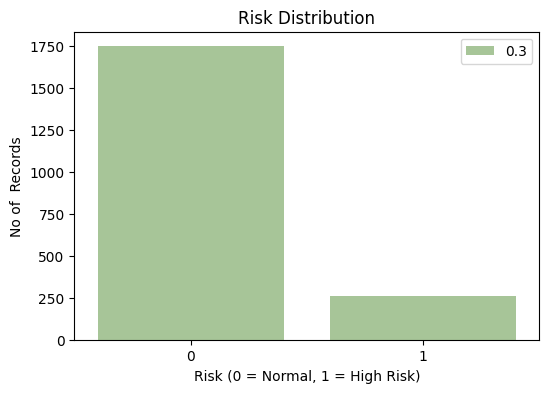

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='risk', data=df,hue=0.3, palette='crest')
plt.title('Risk Distribution')
plt.xlabel('Risk (0 = Normal, 1 = High Risk)')
plt.ylabel('No of  Records')
plt.show()

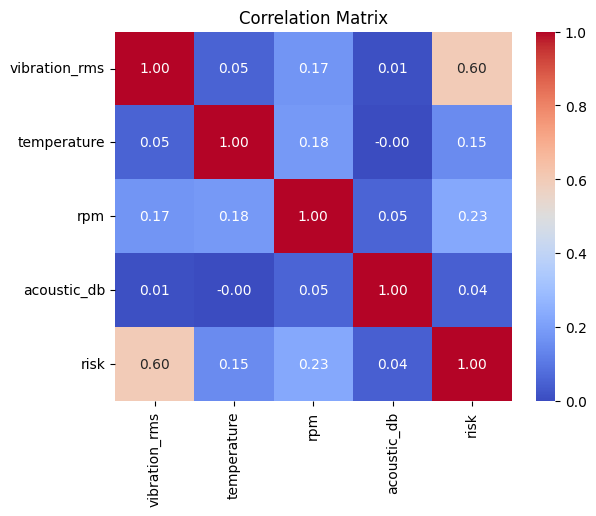

In [6]:
plt.figure()
core = df.corr()
sns.heatmap(core, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

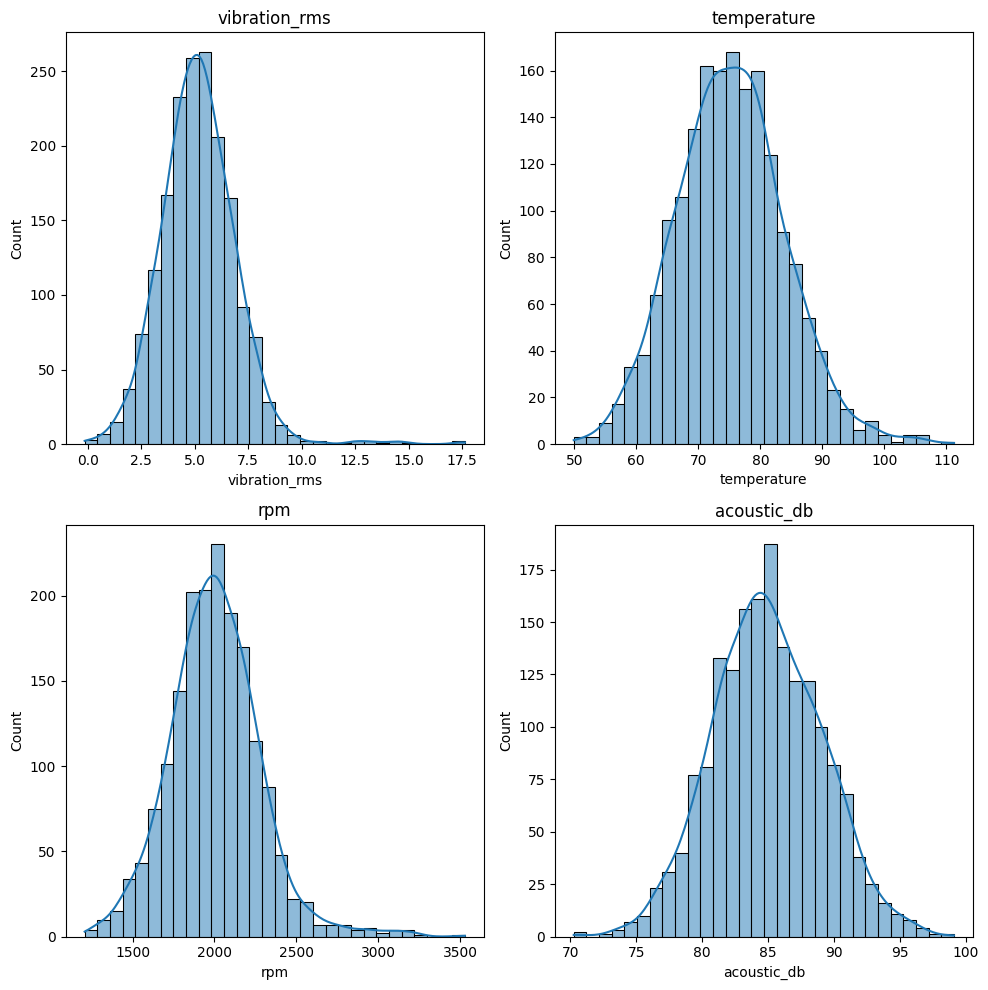

In [7]:
feat = ['vibration_rms', 'temperature', 'rpm', 'acoustic_db']
plt.figure(figsize=(10, 10))
for i, j in enumerate(feat):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[j], kde=True, bins=30)
    plt.title(j)
plt.tight_layout()
plt.show()

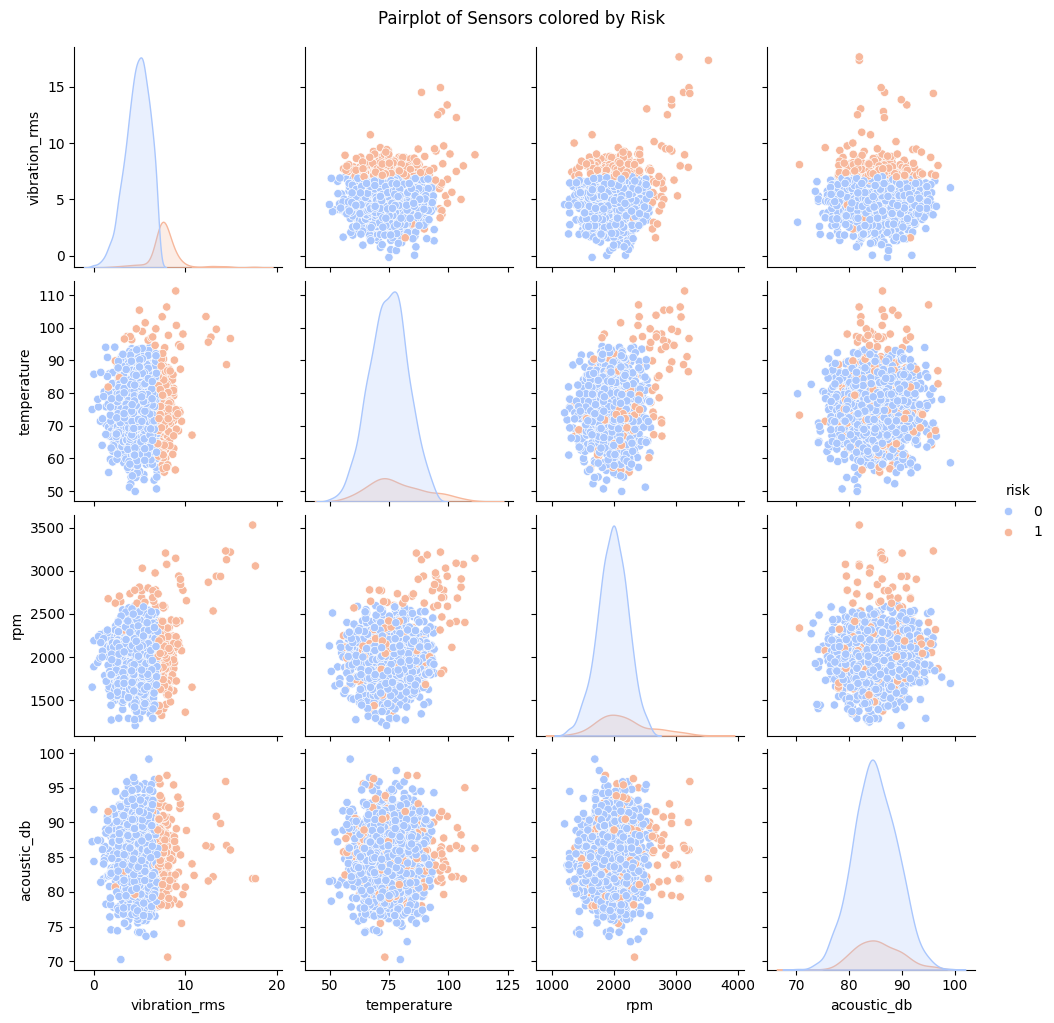

In [8]:
sns.pairplot(df, hue='risk', palette='coolwarm')
plt.suptitle('Pairplot of Sensors colored by Risk', y=1.02)
plt.show()

In [9]:
#To kill the Orange dots in the Blue zone
df = df.drop(df[(df.risk == 1) & (df.vibration_rms < 6) & (df.temperature < 250)].index)
#To fix the Blue dots in the Orange zone
df.loc[(df.vibration_rms > 6) | (df.temperature > 250), 'risk'] = 1

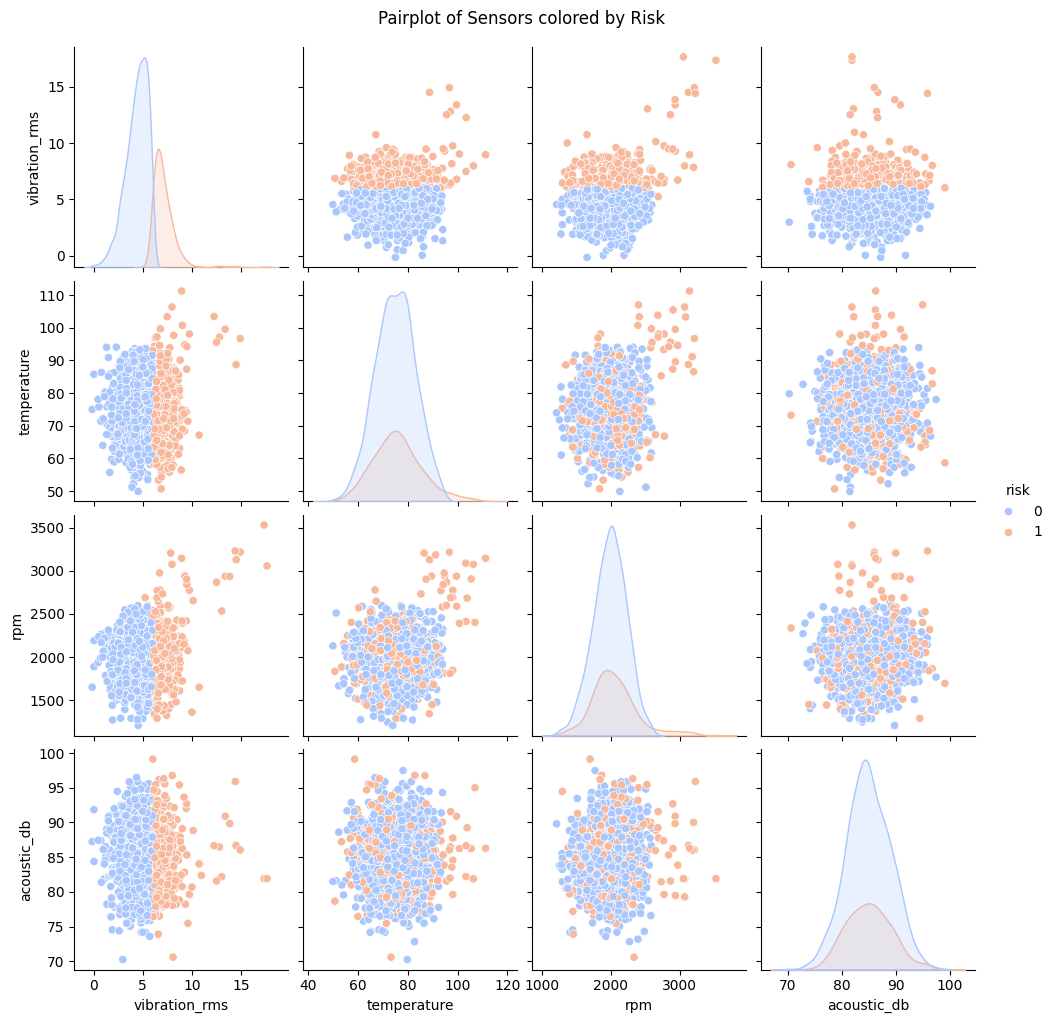

In [10]:
sns.pairplot(df, hue='risk', palette='coolwarm')
plt.suptitle('Pairplot of Sensors colored by Risk', y=1.02)
plt.show()

In [11]:
df_pl = pl.from_pandas(df)
print("Polars DataFrame: \n\n")
print(df_pl.head())

Polars DataFrame: 


shape: (5, 5)
┌───────────────┬─────────────┬─────────────┬─────────────┬──────┐
│ vibration_rms ┆ temperature ┆ rpm         ┆ acoustic_db ┆ risk │
│ ---           ┆ ---         ┆ ---         ┆ ---         ┆ ---  │
│ f64           ┆ f64         ┆ f64         ┆ f64         ┆ i64  │
╞═══════════════╪═════════════╪═════════════╪═════════════╪══════╡
│ 5.728559      ┆ 68.580832   ┆ 1784.126599 ┆ 80.543675   ┆ 0    │
│ 4.540778      ┆ 73.385601   ┆ 1992.199128 ┆ 82.476277   ┆ 0    │
│ null          ┆ 67.764569   ┆ 2004.504218 ┆ 81.231759   ┆ 0    │
│ 7.641911      ┆ 72.701935   ┆ 2118.157586 ┆ 82.808017   ┆ 1    │
│ 5.287698      ┆ 61.64685    ┆ null        ┆ 84.143399   ┆ 0    │
└───────────────┴─────────────┴─────────────┴─────────────┴──────┘


In [12]:
no_of_risk = df_pl.filter(pl.col("risk") == 1)
print(f"\n Total no of filghts with risk: {no_of_risk.shape[0]}")


 Total no of filghts with risk: 532


In [13]:
agg_stats = df_pl.group_by("risk").agg([
    pl.col("vibration_rms").mean().alias("avg_vibration"),
    pl.col("temperature").mean().alias("avg_temperature"),
    pl.col("rpm").max().alias("max_rpm"),
    pl.len().alias("flight_count") 
])

print("\n--- Aggregated Statistics (Polars) ---")
print(agg_stats)


--- Aggregated Statistics (Polars) ---
shape: (2, 5)
┌──────┬───────────────┬─────────────────┬─────────────┬──────────────┐
│ risk ┆ avg_vibration ┆ avg_temperature ┆ max_rpm     ┆ flight_count │
│ ---  ┆ ---           ┆ ---             ┆ ---         ┆ ---          │
│ i64  ┆ f64           ┆ f64             ┆ f64         ┆ u32          │
╞══════╪═══════════════╪═════════════════╪═════════════╪══════════════╡
│ 0    ┆ 4.360313      ┆ 74.883637       ┆ 2597.092998 ┆ 1460         │
│ 1    ┆ 7.184209      ┆ 75.854761       ┆ 3529.543389 ┆ 532          │
└──────┴───────────────┴─────────────────┴─────────────┴──────────────┘


In [14]:
df_pl.write_csv("processed data.csv")

In [15]:
import great_expectations as gx
import pandas as pd
from great_expectations.core.batch import RuntimeBatchRequest

context = gx.get_context()

df = pd.read_csv("processed data.csv")

datasource_config = {
    "name": "aircraft_sensor_source",
    "class_name": "Datasource",
    "execution_engine": {"class_name": "PandasExecutionEngine"},
    "data_connectors": {
        "default_runtime_data_connector_name": {
            "class_name": "RuntimeDataConnector",
            "batch_identifiers": ["default_identifier_name"],
        },
    },
}
context.add_datasource(**datasource_config)

suite_name = "aircraft_sensor_suite"
context.add_or_update_expectation_suite(expectation_suite_name=suite_name)

batch_request = RuntimeBatchRequest(
    datasource_name="aircraft_sensor_source",
    data_connector_name="default_runtime_data_connector_name",
    data_asset_name="aircraft_dataframe",
    runtime_parameters={"batch_data": df},
    batch_identifiers={"default_identifier_name": "default_run"},
)

validator = context.get_validator(
    batch_request=batch_request, expectation_suite_name=suite_name
)

validator.expect_table_row_count_to_be_between(min_value=900, max_value=1100)
validator.expect_column_values_to_not_be_null(column="risk")
validator.expect_column_values_to_not_be_null(column="vibration_rms")
validator.expect_column_values_to_not_be_null(column="temperature")
validator.expect_column_values_to_be_in_set(column="risk", value_set=[0, 1])
validator.expect_column_values_to_be_between(column="temperature", min_value=50, max_value=500)
validator.expect_column_values_to_be_between(column="rpm", min_value=0, max_value=20000)

validator.save_expectation_suite(discard_failed_expectations=False)

results = validator.validate()
print(f"Validation Success: {results.success}")

context.build_data_docs()
context.open_data_docs()

Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/23 [00:00<?, ?it/s]

Validation Success: False


In [16]:
df.fillna(df.median(), inplace=True)
X = df[['vibration_rms', 'temperature', 'rpm', 'acoustic_db']]
y = df['risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 98.75%



			--- Report ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       292
           1       1.00      0.95      0.98       107

    accuracy                           0.99       399
   macro avg       0.99      0.98      0.98       399
weighted avg       0.99      0.99      0.99       399



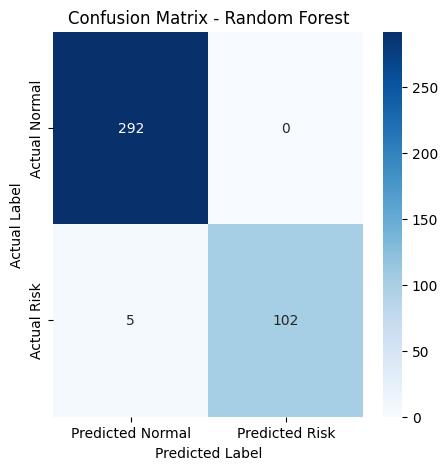


Model saved as pickle file


In [17]:
print("\n\t\t\t--- Report ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Risk'],
            yticklabels=['Actual Normal', 'Actual Risk'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

with open('aircraftmodel.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("\nModel saved as pickle file")

In [ ]:
print("--- 1. Generating SHAP Explanations ---")

explainer = shap.TreeExplainer(rf_model)

explanation = explainer(X_test, check_additivity=False)

shap_values_risk = explanation[:, :, 1]

print("Generating Feature Importance Plot...")

plt.figure(figsize=(10, 6))
plt.title("Global Feature Importance (What drives Risk?)")
shap.plots.bar(shap_values_risk, show=False)
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Detailed Impact Analysis")
shap.plots.beeswarm(shap_values_risk, show=False)
plt.show()

print("\n--- 2. Performing Bias/Fairness Analysis ---")

test_data = X_test.copy()
test_data['actual_risk'] = y_test
test_data['predicted_risk'] = y_pred

group_high_rpm = test_data[test_data['rpm'] > 6000]

group_low_rpm = test_data[test_data['rpm'] <= 6000]

acc_high = accuracy_score(group_high_rpm['actual_risk'], group_high_rpm['predicted_risk'])
acc_low = accuracy_score(group_low_rpm['actual_risk'], group_low_rpm['predicted_risk'])

print(f"Bias Check Report:")
print(f"------------------")
print(f"Accuracy on High RPM Flights: {acc_high:.2%}")
print(f"Accuracy on Low RPM Flights:  {acc_low:.2%}")
print(f"Disparity (Gap):              {abs(acc_high - acc_low):.2%}")

if abs(acc_high - acc_low) < 0.05:
    print("\nCONCLUSION: Model is FAIR. Performance is consistent across engine speeds.")
else:
    print("\nCONCLUSION: Model shows BIAS. It performs significantly better on one group.")